<a href="https://colab.research.google.com/github/ShlokVaibhav/AI_for_Analog_Design/blob/main/Spice_in_Colab_Basic_Convex_Optmzn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
! python --version    # Pyspice works with python  3.9 or lower
!pip install -q gdown

Python 3.11.11
/usr/local/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jpVKXaw5eiSAVzJvBa_URSY5Sgfi3Dj0
To: /content/lib_90nm.txt
100% 10.1k/10.1k [00:00<00:00, 26.6MB/s]


In [15]:
!gdown --id 1jpVKXaw5eiSAVzJvBa_URSY5Sgfi3Dj0 -O lib_90nm.txt

/usr/local/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jpVKXaw5eiSAVzJvBa_URSY5Sgfi3Dj0
To: /content/lib_90nm.txt
100% 10.1k/10.1k [00:00<00:00, 26.8MB/s]


In [1]:
# Source: (S1) https://stackoverflow.com/questions/72133319/oserror-cannot-load-library-libngspice-so-libngspice-so-on-google-colab
# First answer
!pip install -q condacolab
!pip install matplotlib
!pip install numpy
!pip install scipy
import condacolab
condacolab.install()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 132.5 MB/s eta 0:00:00
✨🍰✨ Everything looks OK!


In [3]:
# Installing ngspice [S1] but inside the new environment [S2]
!conda install -c conda-forge ngspice-exe
!conda install -c conda-forge ngspice
!conda install -c conda-forge ngspice-lib

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [1]:
# creating the spice file with 90nm predictive library
# inverter transient transfer curve

def CIR_gen(W):
  Wn = W[0]
  Wp = W[1]
  text = f"""CMOS inverter

  .model mosnb3 NMOS level=8 version=3.3.0 tox=6.5n nch=2.4e17 nsub=5e16 vth0=0.3
  .model mospb3 PMOS level=8 version=3.3.0 tox=6.5n pch=2.4e17 psub=5e16 vth0=0.3
  .include "lib_90nm.txt"
  .option TEMP=27C

  Vpower VD 0 1.5
  Vgnd VS 0 0

  Vgate Ein VS PULSE(0 1.5 1n 0.5n 0.5n 2n 5n)

  *MN0 Aus Ein VS VS MOSN W=10U L=0.18U
  M1  Aus Ein VS VS nmos L=90n W={Wn}n
  *MP0 Aus Ein VD VD MOSP W=20U L=0.18U
  M2  Aus Ein VD VD pmos L=90n W={2*Wp}n

  C1 Aus VS 0.1p

  .tran 0.5ps 6ns
  .control
    run
    wrdata Aus.dat v(Aus)
    wrdata I_SUP.dat -i(Vpower)
  .endc
  .END"""

  # Save to file
  with open("NMOS_test.cir", "w") as f:
      f.write(text)

# Verify
#!cat NMOS_test.cir


In [2]:
# loss function: Average current
def Run_sim(W):
    CIR_gen(W)  # create spice netlist with these widths
    os.system("ngspice -b -o output.log NMOS_test.cir")

def I_gen(W):
    Run_sim(W)
    data = np.loadtxt('I_SUP.dat')
    voltage = data[:, 1]
    I_avg = np.average(voltage)*1e10
    return I_avg

def Fall_Time(W):
  data = np.loadtxt('Aus.dat')  # your .dat file
  #data = np.loadtxt('I_SUP.dat')  # your .dat file

  # If your file has two columns
  t = data[:, 0]   # first column
  V = data[:, 1]  # second column

  v_min = V.min()
  v_max = V.max()
  v10 = v_min + 0.1*(v_max - v_min)
  v90 = v_min + 0.9*(v_max - v_min)
  tf10 = t[np.where(V <= v10)[0][0]]  # first time V crosses 10%
  tf90 = t[np.where(V <= v90)[0][0]]  # first time V crosses 90%
  tf = (tf10 - tf90)*1e9
  return tf

def Rise_Time(W):
  data = np.loadtxt('Aus.dat')  # your .dat file
  #data = np.loadtxt('I_SUP.dat')  # your .dat file

  # If your file has two columns
  t = data[:, 0]   # first column
  V = data[:, 1]  # second column

  v_min = V.min()
  v_max = V.max()
  v10 = v_min + 0.1*(v_max - v_min)
  v90 = v_min + 0.9*(v_max - v_min)
  tr10 = t[np.where((V >= v10) & (t > 3e-9))[0][0]]
  tr90 = t[np.where((V >= v90) & (t > 3e-9))[0][0]]
  tr = (tr90 - tr10)*1e9
  return tr



In [14]:
# minimization algorithm
import numpy as np
from scipy.optimize import minimize
import os

bnds = ((90, 420), (90, 420))
cons = ({'type': 'ineq', 'fun': lambda x : 600000 - 1000000*Rise_Time(x)},
        {'type': 'ineq', 'fun': lambda x: 600000 - 1000000*Fall_Time(x)})

def callback_func(xk):
    print("Current x:", xk)
    print("Rise Time:", Rise_Time(xk))
    print("Fall Time:", Fall_Time(xk))
    print("Current objective:", I_gen(xk))


res = minimize(I_gen, (418, 418), method='SLSQP', bounds=bnds, constraints=cons,     callback=callback_func,
    options={'disp': True}   # also prints final convergence info
)
print(res)

Current x: [376.91015625 311.8203125 ]
Rise Time: 0.4689999999999999
Fall Time: 0.3535000000000001
Current objective: 285302.80469068914
Current x: [145.40118869  90.00000004]
Rise Time: 1.4900000000000004
Fall Time: 0.7585000000000002
Current objective: 248310.46690410058
Current x: [138.60114629  90.        ]
Rise Time: 1.4899999999999995
Fall Time: 0.7935
Current objective: 248089.5140921505
Current x: [139.28408786  90.00000001]
Rise Time: 1.4899999999999995
Fall Time: 0.7895000000000002
Current objective: 248111.9454648085
Current x: [ 90.         101.55181885]
Rise Time: 1.316
Fall Time: 1.204
Current objective: 249822.16437229107
Current x: [ 90.00000075 101.55181862]
Rise Time: 1.316
Fall Time: 1.204
Current objective: 249822.1643830806
Current x: [106.32544653  90.00000501]
Rise Time: 1.4894999999999998
Fall Time: 1.025
Current objective: 246886.95392685864
Current x: [106.32545361  90.        ]
Rise Time: 1.4894999999999998
Fall Time: 1.025
Current objective: 246886.951968124

In [7]:
#running ngspice in batch mode, output log saved in output.log
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting
%matplotlib inline

Wn = np.arange(90, 421, 30)
Wp = np.arange(90, 421, 30)
I_avg = np.zeros((Wn.shape[0], Wp.shape[0]))
Tr = np.zeros((Wn.shape[0], Wp.shape[0]))
Tf = np.zeros((Wn.shape[0], Wp.shape[0]))
Wn_grid, Wp_grid = np.meshgrid(Wn, Wp, indexing='ij')

for i, wn in enumerate(Wn, start=1):
    for j, wp in enumerate(Wp, start=1):
      I_avg[i-1, j-1] = I_gen(np.array([wn, wp]))
      Tr[i-1, j-1] = Rise_Time(np.array([wn, wp]))
      Tf[i-1, j-1] = Fall_Time(np.array([wn, wp]))



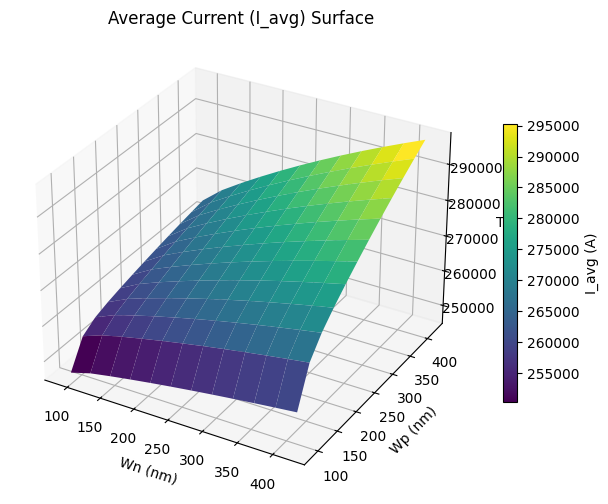

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Wn_grid, Wp_grid, I_avg, cmap='viridis', edgecolor='none')

# Add labels and colorbar
ax.set_title("Average Current (I_avg) Surface")
ax.set_xlabel("Wn (nm)")
ax.set_ylabel("Wp (nm)")
ax.set_zlabel("Tf")
fig.colorbar(surf, ax=ax, shrink=0.6, label='I_avg (A)')

plt.show()

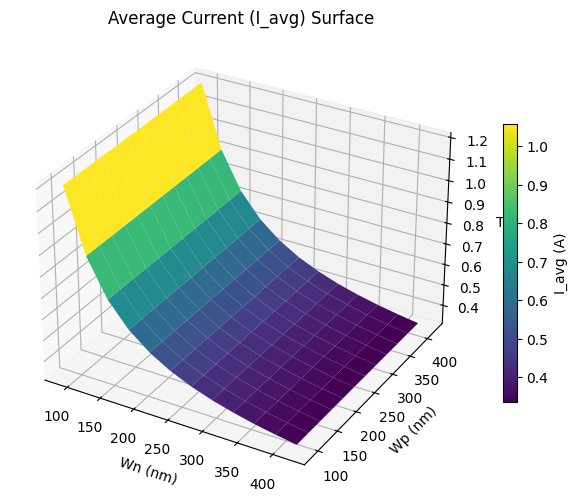

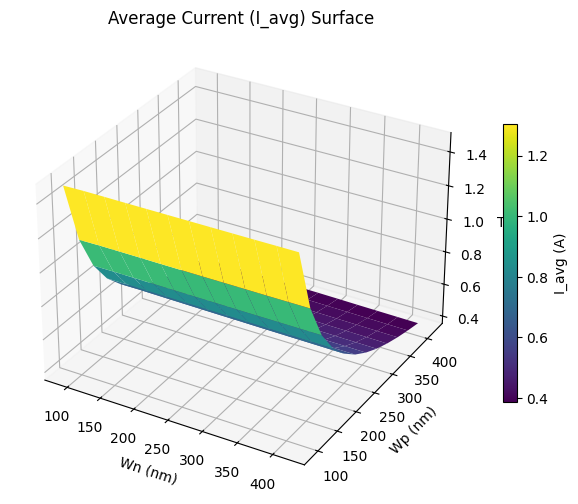

In [62]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Wn_grid, Wp_grid, Tf, cmap='viridis', edgecolor='none')

# Add labels and colorbar
ax.set_title("Average Current (I_avg) Surface")
ax.set_xlabel("Wn (nm)")
ax.set_ylabel("Wp (nm)")
ax.set_zlabel("Tf")
fig.colorbar(surf, ax=ax, shrink=0.6, label='I_avg (A)')

plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Wn_grid, Wp_grid, Tr, cmap='viridis', edgecolor='none')

# Add labels and colorbar
ax.set_title("Average Current (I_avg) Surface")
ax.set_xlabel("Wn (nm)")
ax.set_ylabel("Wp (nm)")
ax.set_zlabel("Tr")
fig.colorbar(surf, ax=ax, shrink=0.6, label='I_avg (A)')

plt.show()


In [ ]:
# read log file
#with open('output.log', 'r') as file:
 #   content = file.read()
  #  print(content)


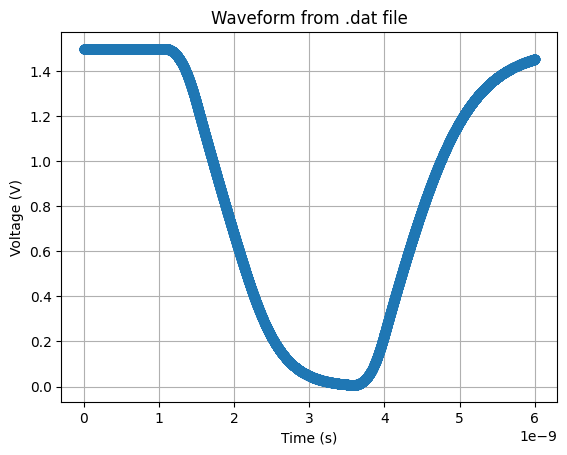

In [57]:
Run_sim(np.array([90, 90]))

data = np.loadtxt('Aus.dat')  # your .dat file
  #data = np.loadtxt('I_SUP.dat')  # your .dat file

  # If your file has two columns
t = data[:, 0]   # first column
V = data[:, 1]  # second column

# Load the data

tr = Rise_Time()
print(tr)




# Plot
plt.plot(t, V, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Waveform from .dat file')
plt.grid(True)
plt.show()



In [35]:
print(np.where(V >= v10))

(array([    0,     1,     2, ..., 12017, 12018, 12019]),)


In [40]:
indices = np.where((V <= v10) & (t > 3e-9))[0][0]

In [41]:
print(indices)

6013
